In [1]:
import pandas as pd
import keras
import os
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from sklearn.manifold import TSNE
import random
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from tokenizer import CustomTokenizer
from wordcloud import WordCloud
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from utils import plot_wordclouds_by_label, plot_review_length_distribution_plotly, plot_text_length_histograms, describe_text_data,longest_and_shortest_reviews,longest_and_shortest_reviews_by_sentiment

# **Learning word vectors for sentiment classification**

### **Goals of this project :**

Based on the approached used in https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf, the goal is to replicate their method and to try similar ideas with up-to-date tools such as modern tokenizers (BERT, which did not exist at the time) and use different learning techniques. 

## **IMDb Dataset**

The IMDb dataset is a movie reviews dataset, which aims at binary sentiment classification. Its size is of 50.000 reviews total :
- 25.000 for training 
- 25.000 for testing 
There are also 50.000 unlabeled reviews that will be used for unsupervised pre-training. 

Each review is a piece of text written by a user, that go through a few sentences to a paragraph. Each review is labeled with label 0 for a negative sentiment, and label 1 for a positive one (the reviews are supposed to be highly polar).

The dataset also includes raw test and bag-of-words format. 

In [2]:
# Load the data with a dictionnary (text is the movie review 
# and label is the positive or negative label)
def load_imdb_data(path, split="train"):
    data = []
    for label in ['pos', 'neg']:
        folder = os.path.join(path, split, label)
        for filename in os.listdir(folder):
            with open(os.path.join(folder, filename), encoding='utf-8') as f:
                text = f.read()
                data.append({
                    'text': text,
                    'label': 1 if label == 'pos' else 0
                })
    return data

train_data = load_imdb_data("data_movie", split="train")
test_data = load_imdb_data("data_movie", split="test")
print(f"Loaded {len(train_data)} train reviews.")
print(f"Loaded {len(test_data)} test reviews.") 

Loaded 25000 train reviews.
Loaded 25000 test reviews.


In [3]:
# Example of what is in the dataset 
print(train_data[2])
print(len(train_data)+len(test_data))

{'text': 'A solid, if unremarkable film. Matthau, as Einstein, was wonderful. My favorite part, and the only thing that would make me go out of my way to see this again, was the wonderful scene with the physicists playing badmitton, I loved the sweaters and the conversation while they waited for Robbins to retrieve the birdie.', 'label': 1}
50000


## **Descriptive analysis** 

First, let us carry a descriptive analysis of the train and test set (and maybe one of the unsupervised set as well since it is used next). 
The goal is to see basic statistics (number of samples, disctribution of labels,average length text in tokens), but also textual insights (the most frequent tokens, vocabulary size, longest/shortest reviews and possible outliers), and finally some global visualizations (histogram of text length, bar plot of label distribution).

In [4]:
# We split the loaded datasets into the text and the associated label 

train_texts = [sample['text'] for sample in train_data]
train_labels = [sample['label'] for sample in train_data]
test_texts = [sample['text'] for sample in test_data]
test_labels = [sample['label'] for sample in test_data]

In [5]:
# Tokenization : first approach same as in the paper, using a simple custom tokenizer
# based on splitting words 
desc_df = describe_text_data(train_data, test_data, tokenizer=CustomTokenizer())
desc_df

,Set,Size,Label 0 (%),Label 1 (%),Avg Length,Min Length,Max Length
0,Train,25000,50.0,50.0,264.04928,11,2707
1,Test,25000,50.0,50.0,258.26864,8,2534


We are reassured because the datasets are well balanced (same size for both). There is the same proportion of positive and negative labels in both datasets and it reaches 50% for both, which is very positive. 

The lengths go through a sentence to on average 2600 tokens maximum as expected. 

In [6]:
# To get an idea of most frequent words and the overlap in the vocabulary 
tokenizer = CustomTokenizer()
tokenizer.build_vocab(train_texts + test_texts)


# --- Most frequent tokens ---
top_tokens = tokenizer.token_freqs.most_common(50)
print("\nTop 50 Most Common Tokens:")
for token, freq in top_tokens:
    print(f"{token:>10} : {freq}")

# --- Vocabulary Overlap ---
train_vocab = set(t for text in train_texts for t in tokenizer.tokenize(text))
test_vocab = set(t for text in test_texts for t in tokenizer.tokenize(text))
shared_vocab = train_vocab & test_vocab

print(f"\nVocab Overlap: {len(shared_vocab)} shared tokens")
print(f"Train-only tokens: {len(train_vocab - test_vocab)}")
print(f"Test-only tokens:  {len(test_vocab - train_vocab)}\n")



Top 50 Most Common Tokens:
       the : 664899
         . : 650512
         , : 544817
       and : 322766
         a : 321519
        of : 288573
        to : 267105
        is : 210834
        in : 185391
        it : 156241
         i : 154503
      this : 150725
      that : 136807
         " : 131856
       was : 95506
        as : 91522
      with : 87195
       for : 87033
     movie : 85799
       but : 83144
      film : 76332
         ) : 71267
         ( : 69585
        on : 67105
       not : 60280
       you : 60113
       are : 58314
       his : 57400
      have : 55131
        be : 52944
        he : 52300
       one : 51690
         ! : 49162
        at : 46659
       all : 45932
        by : 44219
        an : 42855
      they : 41819
       who : 40467
      from : 40427
        so : 39940
      like : 39208
        or : 35248
      just : 35049
       her : 34596
     about : 34105
        if : 33887
      it's : 33313
       out : 33110
       has : 32984

Vocab O

In [7]:
def get_extreme_reviews_by_sentiment(train_data, tokenizer, num_reviews=5):
    """
    Returns the shortest and longest reviews by sentiment (positive and negative).

    Parameters
    ----------
    train_data : list of dict
        Each dict must contain 'text' and 'label' (0 = negative, 1 = positive).
    tokenizer : object
        HuggingFace tokenizer with a .tokenize() method.
    num_reviews : int
        Number of shortest/longest reviews to return per class.

    Returns
    -------
    Dict with keys:
        - 'shortest_negative'
        - 'shortest_positive'
        - 'longest_negative'
        - 'longest_positive'
      Each maps to a list of tuples: (token_length, review_text)
    """
    # Separate reviews by label
    negative_reviews = [
        (len(tokenizer.tokenize(sample['text'])), sample['text'])
        for sample in train_data if sample['label'] == 0
    ]
    positive_reviews = [
        (len(tokenizer.tokenize(sample['text'])), sample['text'])
        for sample in train_data if sample['label'] == 1
    ]

    # Sort each group by token length
    negative_reviews.sort(key=lambda x: x[0])
    positive_reviews.sort(key=lambda x: x[0])

    return {
        'shortest_negative': negative_reviews[:num_reviews],
        'longest_negative': negative_reviews[-num_reviews:],
        'shortest_positive': positive_reviews[:num_reviews],
        'longest_positive': positive_reviews[-num_reviews:]
    }

result = get_extreme_reviews_by_sentiment(train_data, tokenizer, num_reviews=5)

print("\n--- 5 Shortest Negative Reviews ---")
for length, text in result['shortest_negative']:
    print(f"\nLength: {length} tokens\n{text[:300]}...\n")

print("\n--- 5 Shortest Positive Reviews ---")
for length, text in result['shortest_positive']:
    print(f"\nLength: {length} tokens\n{text[:300]}...\n")

print("\n--- 5 Longest Negative Reviews ---")
for length, text in result['longest_negative']:
    print(f"\nLength: {length} tokens\n{text[:500]}...\n")

print("\n--- 5 Longest Positive Reviews ---")
for length, text in result['longest_positive']:
    print(f"\nLength: {length} tokens\n{text[:500]}...\n")




--- 5 Shortest Negative Reviews ---

Length: 11 tokens
I wouldn't rent this one even on dollar rental night....


Length: 11 tokens
This movie is terrible but it has some good effects....


Length: 12 tokens
You'd better choose Paul Verhoeven's even if you have watched it....


Length: 13 tokens
Ming The Merciless does a little Bardwork and a movie most foul!...


Length: 18 tokens
Long, boring, blasphemous. Never have I been so glad to see ending credits roll....


--- 5 Shortest Positive Reviews ---

Length: 14 tokens
Adrian Pasdar is excellent is this film. He makes a fascinating woman....


Length: 20 tokens
I don't know why I like this movie so well, but I never get tired of watching it....


Length: 20 tokens
This is the definitive movie version of Hamlet. Branagh cuts nothing, but there are no wasted moments....


Length: 24 tokens
Touching; Well directed autobiography of a talented young director/producer. A love story with Rabin's assassination in the background. Worth seeing

In [8]:
# --- Longest/Shortest Reviews by sentiment ---
longest_and_shortest_reviews_by_sentiment(train_data,tokenizer = CustomTokenizer())


Shortest 5 Positive Reviews:
Length: 14 tokens
Adrian Pasdar is excellent is this film. He makes a fascinating woman....


Shortest 5 Negative Reviews:
Length: 11 tokens
I wouldn't rent this one even on dollar rental night....

Length: 11 tokens
This movie is terrible but it has some good effects....

Length: 12 tokens
You'd better choose Paul Verhoeven's even if you have watched it....

Length: 13 tokens
Ming The Merciless does a little Bardwork and a movie most foul!...


Longest 5 Positive Reviews:
Length: 1925 tokens
*!!- SPOILERS - !!*<br /><br />Before I begin this, let me say that I have had both the advantages of seeing this movie on the big screen and of having seen the "Authorized Version" of this movie, remade by Stephen King, himself, in 1997.<br /><br />Both advantages made me appreciate this version of "The Shining," all the more.<br /><br />Also, let me say that I've read Mr. King's book, "The Shining" on many occasions over the years, and while I love the book and am a

{'positive_shortest': [(14,
   'Adrian Pasdar is excellent is this film. He makes a fascinating woman.')],
 'negative_shortest': [(11,
   "I wouldn't rent this one even on dollar rental night."),
  (11, 'This movie is terrible but it has some good effects.'),
  (12, "You'd better choose Paul Verhoeven's even if you have watched it."),
  (13, 'Ming The Merciless does a little Bardwork and a movie most foul!')],
 'positive_longest': [(1925,
   '*!!- SPOILERS - !!*<br /><br />Before I begin this, let me say that I have had both the advantages of seeing this movie on the big screen and of having seen the "Authorized Version" of this movie, remade by Stephen King, himself, in 1997.<br /><br />Both advantages made me appreciate this version of "The Shining," all the more.<br /><br />Also, let me say that I\'ve read Mr. King\'s book, "The Shining" on many occasions over the years, and while I love the book and am a huge fan of his work, Stanley Kubrick\'s retelling of this story is far more c

In [9]:
# Plot the distribution of the length of the reviews 
plot_text_length_histograms(train_data,test_data,tokenizer=CustomTokenizer())

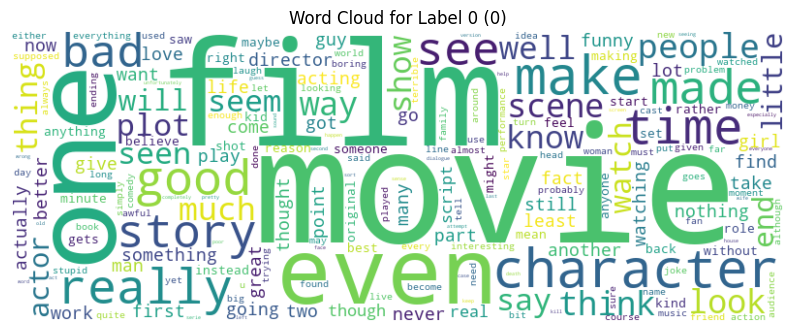

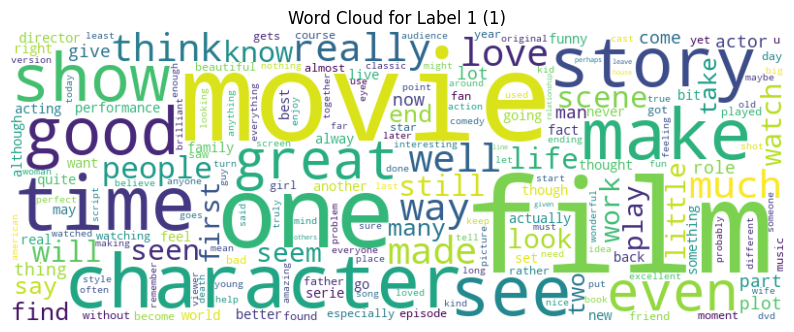

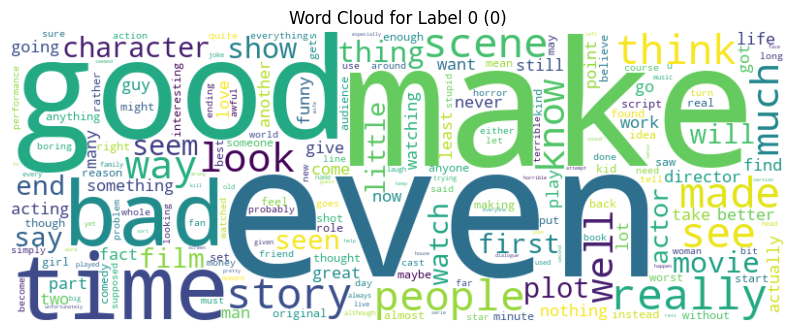

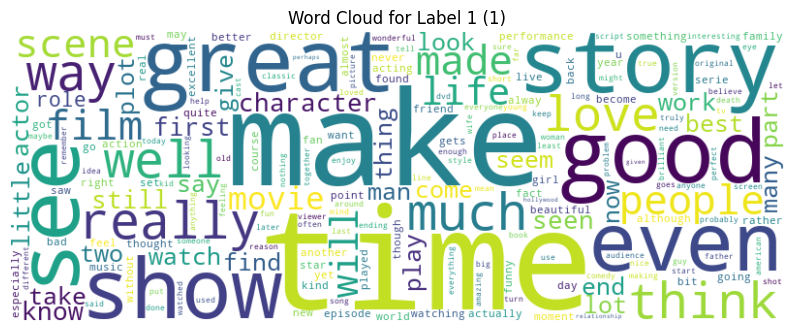

In [10]:
# First test of wordcloud
plot_wordclouds_by_label(train_texts, train_labels,tokenizer=CustomTokenizer())

# And if we want to add more stop words to see a bit more of the polarity 
plot_wordclouds_by_label(train_texts, train_labels,tokenizer=CustomTokenizer(),stop_words={"br", "the", "and", "is", "it", "to", "of","movie","film","one","character"})

The wordcloud is strange since there is no huge difference between the negative reviews (label 0) and the positive ones (label 1)... That might explain the poor results of the model later. 

In [11]:
# Plot the link between the length of the review and the label 
plot_review_length_distribution_plotly(train_data, tokenizer=CustomTokenizer())

## **Unsupervised part and word representation**

I use the unsupervised part of the train set in order to learn word embeddings. I will compare the results of known embeddings such as Word2Vec, GloVe, and FastText, Collobert, BERT (contextuel). 


In [12]:
# Load the unsupervised data 

def load_unsupervised_data(path):
    data = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), encoding='utf-8') as f:
            text = f.read()
            data.append(text)  # store only text since they are unlabeled
    return data

unsupervised_data = load_unsupervised_data("data_movie/train/unsup")
print(f"Loaded {len(unsupervised_data)} unsupervised reviews.")

Loaded 50000 unsupervised reviews.


**First approach : building a custom tokenizer**
For the first approach, I use regex in order to make punctuation be a token because I could get things like : 
- "wonderful!!!" and if I don't split the punctuation, the token would be ["wonderful!!!"] while I would like it to be ["wonderful","!!!"]
- then I just split by spaces to get the tokens.
- The paper used a simple tokenizer because BERT did not exist at the time so my first approach will be to replicate this. They build a fixed dictionary of the 5.000 most frequent tokens, but ignore the 50 most frequent terms from the original full vocabulary. They do not stem or remove stop words such as punctuation '!',':-)' since they induce sentiment. 


In [13]:
# Tokenize from training data to prevent data leakage from the test data and 
# to allow better generalization

train_texts = [sample['text'] for sample in train_data]
tokenizer = CustomTokenizer()

vocab_dict = tokenizer.build_vocab(train_texts)


print("\n--- Vocabulary Preview (first 50 words after special tokens) ---")
for i, (word, idx) in enumerate(list(tokenizer.vocab.items())[2:52], start=1):
    print(f"{idx:4} : {word}")


--- Vocabulary Preview (first 50 words after special tokens) ---
   2 : ?
   3 : some
   4 : there
   5 : what
   6 : good
   7 : more
   8 : when
   9 : very
  10 : even
  11 : she
  12 : my
  13 : no
  14 : up
  15 : time
  16 : would
  17 : which
  18 : only
  19 : really
  20 : story
  21 : their
  22 : see
  23 : had
  24 : can
  25 : were
  26 : me
  27 : :
  28 : than
  29 : we
  30 : -
  31 : well
  32 : much
  33 : been
  34 : get
  35 : will
  36 : also
  37 : into
  38 : bad
  39 : people
  40 : do
  41 : other
  42 : because
  43 : great
  44 : first
  45 : how
  46 : him
  47 : most
  48 : don't
  49 : its
  50 : made
  51 : then


In [14]:
# Unsupervised data : tokenization  

unsup_tokenized = [tokenizer.tokenize(text) for text in unsupervised_data]

In [15]:
unsup_tokenized[0]

['a',
 'newspaperman',
 '(',
 'johnny',
 'twennies',
 ')',
 'living',
 'in',
 'the',
 "90's",
 'with',
 'a',
 'complete',
 "20's",
 'personality',
 'and',
 'lifestyle',
 '-',
 'fedora',
 ',',
 'manual',
 'typewriter',
 ',',
 'the',
 'charleston',
 ',',
 'the',
 'works',
 '.',
 "it's",
 'a',
 'great',
 'idea',
 'for',
 'a',
 'movie',
 'and',
 'it',
 "couldn't",
 'have',
 'been',
 'done',
 'better',
 '.',
 'johnny',
 "doesn't",
 'miss',
 'a',
 'cliche',
 ',',
 'but',
 'never',
 'uses',
 'the',
 'same',
 'one',
 'twice',
 '.',
 "you'll",
 'find',
 'yourself',
 'anticipating',
 'his',
 'reactions',
 'to',
 'the',
 'harsher',
 "'90s",
 'world',
 'as',
 'the',
 'movie',
 'goes',
 'along',
 ',',
 "you'll",
 'often',
 'guess',
 'right',
 '-',
 'but',
 'that',
 'makes',
 'the',
 'movie',
 'just',
 'that',
 'much',
 'more',
 'fun',
 '.',
 'lots',
 'of',
 'fun',
 'when',
 'johnny',
 'is',
 'called',
 'on',
 'to',
 'save',
 'the',
 'same',
 'damsel',
 'in',
 'distress',
 '(',
 'named',
 'virginia'

Tokenization seems to work well, and we still have the information of ['don't'] and not ['do','n't'] which is questionable for sentiment analysis. 

The tokenization step is now done so we can encode the dataset to convert each text review into a sequence of integers (token ids) :

In [16]:
# Encoding the data 

encoded_train = []
for sample in train_data:
    encoded = tokenizer.encode(sample['text'])
    encoded_train.append({
        'input_ids': encoded,
        'label': sample['label']
    })

encoded_test = []
for sample in test_data:
    encoded = tokenizer.encode(sample['text'])
    encoded_test.append({
        'input_ids': encoded,
        'label': sample['label']
    })

In [17]:
print(encoded_train[1])

{'input_ids': [1088, 159, 1, 1080, 1, 741, 1497, 1, 2490, 1, 1, 1, 1, 256, 1, 1, 1, 1, 1275, 1, 1, 1, 1, 138, 1, 589, 1, 2208, 1, 1, 1, 1739, 1, 1, 1, 1, 963, 1, 1, 3239, 1, 1, 1, 1, 1, 1, 565, 1, 1, 96, 1, 1, 1, 1, 9, 31, 1914, 1, 1, 1236, 185, 1, 356, 1, 1, 1, 1, 1150, 1, 1, 4904, 1, 1, 8, 1, 1040, 37, 1, 888, 4150, 4905, 1, 1, 1, 1, 1, 1961, 2233, 1, 1, 376, 1788, 1, 1, 137, 19, 329, 1, 1, 1, 4634, 1, 537, 1, 1, 3670, 1, 1, 1, 1, 328, 1, 1999, 147, 1, 1, 1, 1, 1, 1, 131, 1, 1, 1, 1, 1, 43, 205, 1, 1, 1, 516, 1205, 1, 1, 1, 1, 693, 1, 1, 1, 1, 1, 860, 1, 1, 1, 1, 1, 1, 1, 5, 1, 2102, 1, 415, 1, 1, 1, 1, 3980, 1, 1, 1, 1, 1, 1, 1, 1, 3543, 1, 342, 1, 1, 775, 88, 31, 1, 132, 442, 2222, 1, 1, 1, 1, 1, 1, 231, 1, 2604, 1, 1, 1, 1817], 'label': 1}


There is a vocab file from the dataset but I do not use it for now since its size is way larger than 5000 (it must come from more reviews) and I will see first if my vocabulary is enough.

Now that the data is encoded, the next step is to apply some padding in order to have the same length as input for the models.

In [18]:
# Padding based on the largest sentence (token wise)

max_length = max(len(sample['input_ids']) for sample in encoded_train)
print(f"Maximum sequence length in the training data: {max_length}")


def pad_sequences(sequences, max_length, pad_token_id=0):
    padded_sequences = []
    for seq in sequences:
        padding = [pad_token_id] * (max_length - len(seq))  # Pad to the right
        padded_sequences.append(seq + padding if len(seq) < max_length else seq[:max_length])
    return padded_sequences


# Apply padding to the encoded data
padded_encoded_train = pad_sequences([sample['input_ids'] for sample in encoded_train], max_length)
padded_encoded_test = pad_sequences([sample['input_ids'] for sample in encoded_test], max_length)

padded_train_data = [{'input_ids': seq, 'label': sample['label']} for seq, sample in zip(padded_encoded_train, encoded_train)]
padded_test_data = [{'input_ids': seq, 'label': sample['label']} for seq, sample in zip(padded_encoded_test, encoded_test)]


Maximum sequence length in the training data: 2707


In [19]:
print(f"Example padded train data: {padded_train_data[0]}")
print(f"Example padded test data: {padded_test_data[0]}")

Example padded train data: {'input_ids': [1, 1, 1, 1, 168, 13, 1112, 4, 204, 1, 1, 131, 1, 847, 4252, 3439, 1, 1, 1430, 1, 776, 1, 1, 75, 851, 1, 1, 118, 120, 1, 1, 1, 1, 1, 94, 1, 1, 1, 1, 68, 1, 1, 1464, 1969, 1, 62, 1, 1521, 1, 1, 1, 1, 1, 1697, 1, 1, 1, 516, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Now that dataset imdb is loaded, we can try to tokenize the text and build a vocab

Let us now train our own embedding in a first approach, instead of using pre trained embeddings such as GLoVE, Collobert, BERT. I use Word2Vec to do so, on the unsupervised data. Then, I will use BERT which will likely result in better performance. 
We want 50-dimensional vectors (embeddings) in conformity with the article.

#### **Word2Vec**

In [20]:
# Creation of the unsupervised embedding using Word2Vec

# I set vector_size = 50 same as the dimensional vectors of the article 
#and min_count = 5 because they filter words that appear less than 5 times 

# CBOW model (predict target)
model = Word2Vec(sentences=unsup_tokenized,vector_size=50,window=5,min_count=5,workers=4) 
model.save("word2vec_model")

# Skip-gram model (predict context)
model_sg = Word2Vec(sentences=unsup_tokenized,vector_size=50,window=5,min_count=5,workers=4,sg=1) 
model_sg.save("word2vec_model_skipgram")

In [21]:
# Test of the embedding 
word_vector = model.wv['good']
print(f"Embedding for 'good': {word_vector}")


Embedding for 'good': [-0.8835419  -1.5004966  -1.5470974   0.9483699  -0.07804108 -0.66396075
 -4.653939   -3.1882966   1.3094785   3.478596   -3.615868    0.64287776
 -2.6696434  -0.04658787 -1.5967317  -2.0875587  -3.0421095   0.7350997
  1.0603371   4.3102465  -1.0433613   3.3245215   1.6265658   3.561434
 -4.076081    3.046287   -0.62146163  2.9191754  -0.603542    2.8876917
  4.3326416  -0.4066139   2.6256726  -2.9696355  -1.1246693  -0.99244934
 -0.7965065   1.5296309   1.084933   -1.6351757  -2.2776246  -3.1397629
 -3.067127   -0.21476768  1.257996    1.1761572  -2.8770788   0.8171785
 -3.1307333  -1.1227338 ]


Now, let us test the modelled embedding thanks to cosine similarity and some query words : 

In [22]:
# Cosine similarity function 

def cosine_similarity(word1, word2, model):
    # Get word vectors for word1 and word2
    vector1 = model.wv[word1]
    vector2 = model.wv[word2]
    
    # Compute cosine similarity using scipy
    return 1 - cosine(vector1, vector2)

In [23]:
# Test with a query word such as 'romantic' like in the article 

query_words = ["sadness","witty","dull","romantic"]
top_n = 5

# Most similar words
for w in query_words: 
    similar_words = model.wv.most_similar(w, topn=top_n)

    print(f"\nMost similar words to '{w}':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")



Most similar words to 'sadness':
frustration: 0.8717
warmth: 0.8704
despair: 0.8652
loneliness: 0.8631
sorrow: 0.8526

Most similar words to 'witty':
quirky: 0.8449
well-written: 0.8076
humorous: 0.7936
melodramatic: 0.7869
thoughtful: 0.7768

Most similar words to 'dull':
predictable: 0.9310
boring: 0.9173
tedious: 0.9044
bland: 0.8731
contrived: 0.8665

Most similar words to 'romantic':
quirky: 0.7810
romance: 0.7576
light-hearted: 0.7498
erotic: 0.7494
touching: 0.7290


The Word2Vec trained embedding seems to be quite good at finding similar words to the query words in entry !
It captures word semantics based on co-occurrence statistics. However, it does not explicitly capture sentiment information. We will know refine embeddings to predict sentiment labels (positive or negative polarity) thanks to the labels (supervised part).

## **Other word representations**

- LSA : Another approach consists in Latent Semantic Analysis (LSA). Here, is applied a SVD to a tf.idf weighted, cosine normalized count matrix. 
- LDA : Latent Dirichlet Allocation. 

LSA uses tf-idf ie a heuristic weighting scheme based on frequency and inverse document frequency so not probabilistic contrary to LDA that uses raw term counts to assume documents are mixtures of topics, and each topic a distribution of words.

#### **LSA**

In [24]:
# Create TF-IDF matrix
tokenizer = CustomTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize)

X = vectorizer.fit_transform(train_texts)  # TF-IDF matrix 

#norm_X = X / np.linalg.norm(X, axis=1, keepdims=True)
# crash ici car matrice X a de grandes chances d'être sparse
# donc à la place : normaliser avc sklearn 

# Normalization 
norm_X = normalize(X, norm='l2', axis=1)

# SVD decomposition 
n_components = 100  # (100-300 courant pour LSA)
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(norm_X)

# Extraction of word vectors 
# Vocabulary (word -> index) as seen by TfidfVectorizer
vocab_lsa = vectorizer.get_feature_names_out()
word_to_index_lsa = {word: idx for idx, word in enumerate(vocab_lsa)}

# Transpose for "word-vector" (LSA) representation 
# X_svd est document × composantes → on veut terme × composantes
term_vectors_lsa = svd.components_.T  # shape: (n_terms, n_components)


/Users/lila/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [25]:
# Test on query words 
from sklearn.metrics.pairwise import cosine_similarity

query_words = ["sadness", "witty", "dull", "romantic"]
top_n = 5

for query_word in query_words:
    if query_word not in word_to_index_lsa:
        print(f"'{query_word}' n'est pas dans le vocabulaire.")
        continue

    query_idx = word_to_index_lsa[query_word]
    query_vector = term_vectors_lsa[query_idx].reshape(1, -1)

    # Compute cosine similarity between that word and others
    similarities = cosine_similarity(query_vector, term_vectors_lsa)[0]

    # Get indices of most similar words
    similar_indices = similarities.argsort()[::-1][1:top_n + 1]  # on skip le mot lui-même

    print(f"\nMost similar words to '{query_word}':")
    for idx in similar_indices:
        print(f"{vocab_lsa[idx]}: {similarities[idx]:.4f}")



Most similar words to 'sadness':
happiness: 0.5882
cry: 0.5585
emotions: 0.5230
hearts: 0.5192
loneliness: 0.5152

Most similar words to 'witty':
wit: 0.5431
timing: 0.5390
comedic: 0.5189
quirky: 0.5188
charm: 0.4990

Most similar words to 'dull':
boring: 0.6112
tedious: 0.6066
pointless: 0.5637
there's: 0.5411
nothing: 0.5384

Most similar words to 'romantic':
einstein: 0.7049
romance: 0.6843
meg: 0.6593
screwball: 0.6434
comedies: 0.6390


#### **LDA** 
The ultimate test I wanted to implement is to try the LDA approach (Latent Dirichlet Allocation). It works almost like LSA but while LSA produces a continuous vector space, LDA produces probability distributions on topics (discreet and interpretable).

In [26]:
tokenizer = CustomTokenizer()
tokenizer.build_vocab(train_texts)


vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, max_features=5000)
X_train_counts = vectorizer.fit_transform(train_texts)
X_test_counts = vectorizer.transform(test_texts)


vocab_lda = vectorizer.get_feature_names_out()
word_to_index_lda = {word: idx for idx, word in enumerate(vocab_lda)}

n_topics = 50  # number of topics 
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_train_counts)

# Shape: (n_topics, n_words)
topic_word_distrib_lda = lda.components_  # number of times a word is generated by a topic

# Normalize to get probabilities distributions (somme = 1)
word_topic_vectors_lda = topic_word_distrib_lda.T / topic_word_distrib_lda.T.sum(axis=1, keepdims=True)


/Users/lila/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [27]:
# Test 
from sklearn.metrics.pairwise import cosine_similarity

query_words = ["sadness", "witty", "dull", "romantic"]
top_n = 5

for query_word in query_words:
    if query_word not in word_to_index_lda:
        print(f"'{query_word}' n'est pas dans le vocabulaire.")
        continue

    query_idx = word_to_index_lda[query_word]
    query_vector = word_topic_vectors_lda[query_idx].reshape(1, -1)

    similarities = cosine_similarity(query_vector, word_topic_vectors_lda)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]

    print(f"\nMost similar words to '{query_word}' (LDA-based):")
    for idx in similar_indices:
        print(f"{vocab_lda[idx]}: {similarities[idx]:.4f}")



Most similar words to 'sadness' (LDA-based):
capturing: 0.9605
complexity: 0.9603
human: 0.9562
humanity: 0.9559
society: 0.9541

Most similar words to 'witty' (LDA-based):
lovable: 0.8273
romantic: 0.8263
stellar: 0.8071
charming: 0.8004
pleasant: 0.7915

Most similar words to 'dull' (LDA-based):
clichéd: 0.9629
cheap: 0.9529
mediocre: 0.9509
horribly: 0.9457
pointless: 0.9347

Most similar words to 'romantic' (LDA-based):
lovable: 0.9445
pleasant: 0.9437
likable: 0.9092
charming: 0.9029
nicely: 0.8975


Some of the words seem strange in their closeness to the query word. For instance "lovable" both for "witty" and "romantic" do not seem to be so close or even "clichéd" seems unexistant, which is because the words closest are taken from the built vocabulary. 

#### **BERT** 

Let us now try more advanced methods not mentionned in the paper (sentence transformers or tokenizers such as BERT,...) to obtain better sentence representations. 

In [28]:
from transformers import BertTokenizer

# Load pretrained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode texts
train_bert_encoded = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
test_bert_encoded = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

/Users/lila/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [29]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

vocab = list(set(" ".join(train_texts).split()))  

vocab = [w.lower() for w in vocab if w.isalpha() and len(w) > 2]

# Compute BERT embeddings for each word
def get_word_embedding(word):
    inputs = bert_tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_model(**inputs)
    token_embeddings = outputs.last_hidden_state.squeeze(0)  # shape: (seq_len, hidden_size)
    word_embedding = token_embeddings.mean(dim=0)  # mean pooling 
    return word_embedding.numpy()

# Build the embedding dictionary
word_to_embedding = {}
for word in tqdm(vocab):
    try:
        word_to_embedding[word] = get_word_embedding(word)
    except:
        continue # if tokens not handled well

# Matrix for similarity search
all_words = list(word_to_embedding.keys())
embedding_matrix = np.vstack([word_to_embedding[word] for word in all_words])

# Similarity search
query_words = ["sadness", "witty", "dull", "romantic"]
top_n = 5

for query_word in query_words:
    if query_word not in word_to_embedding:
        print(f"\n'{query_word}' is not in the BERT vocabulary (or tokenization issue).")
        continue

    query_vector = word_to_embedding[query_word].reshape(1, -1)
    similarities = cosine_similarity(query_vector, embedding_matrix)[0]
    top_indices = similarities.argsort()[::-1][1:top_n + 1]

    print(f"\nMost similar words to '{query_word}' (BERT-based):")
    for idx in top_indices:
        print(f"{all_words[idx]}: {similarities[idx]:.4f}")

/Users/lila/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning:

`torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.

/Users/lila/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

100%|██████████| 74845/74845 [2:10:58<00:00,  9.52it/s]     



Most similar words to 'sadness' (BERT-based):
sad: 0.9589
anguish: 0.9469
grief: 0.9462
regret: 0.9342
compassion: 0.9323

Most similar words to 'witty' (BERT-based):
comedies: 0.9465
sarcastic: 0.9431
stimulating: 0.9378
downfall: 0.9372
unconventional: 0.9370

Most similar words to 'dull' (BERT-based):
painful: 0.9467
depressed: 0.9451
shiny: 0.9451
smoky: 0.9443
dismay: 0.9443

Most similar words to 'romantic' (BERT-based):
sentimental: 0.9294
sensual: 0.9209
romance: 0.9172
sexual: 0.9068
flirting: 0.9060


Let us try to visualize how words are embedded, to get a better idea of the differences between the representations.

BERT embedding: 100%|██████████| 1000/1000 [00:08<00:00, 117.94it/s]
/Users/lila/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 150 (\x96) missing from font(s) DejaVu Sans.



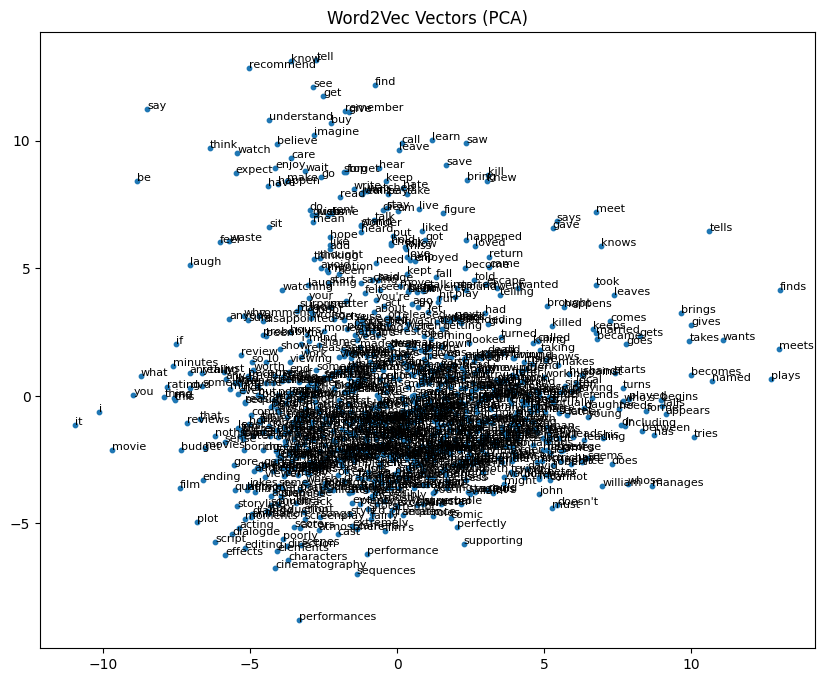

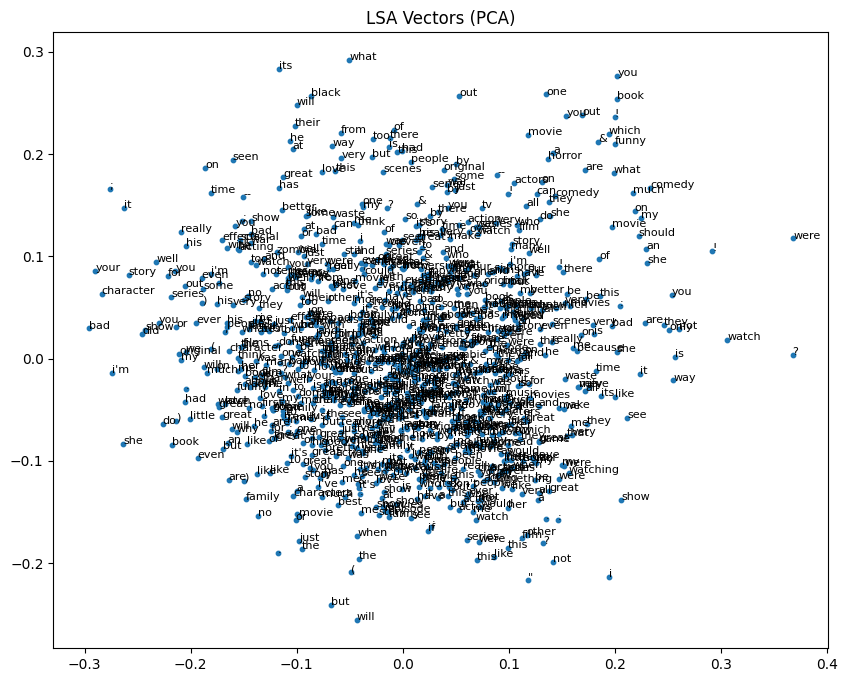

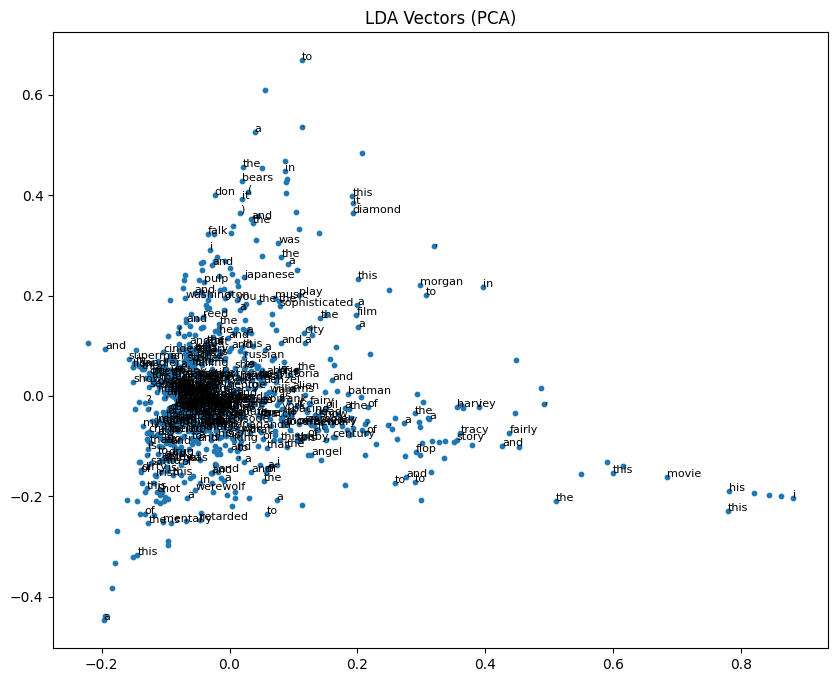

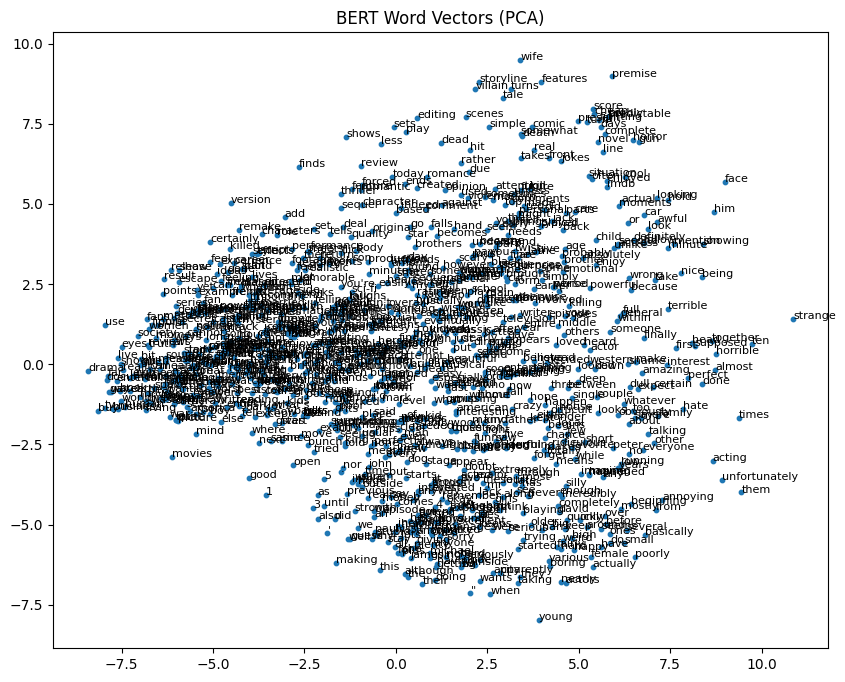

In [30]:
# Some visualisations with PCA (encountered error with t-SNE) 
# in order to see the difference of embeddings according to the model : 

word2vec_model = Word2Vec.load("word2vec_model")

# Word2Vec
w2v_words = list(word2vec_model.wv.index_to_key)
w2v_vectors = np.array([word2vec_model.wv[word] for word in w2v_words])

# LSA
lsa_vectors = term_vectors_lsa
lsa_words = vocab_lsa
lsa_vectors_sample = lsa_vectors

# LDA
lda_vectors = topic_word_distrib_lda # shape: (vocab_size, n_topics)
lda_words = vocab_lda
lda_vectors_sample = lda_vectors

# BERT 
selected_words = word2vec_model.wv.index_to_key[:1000] 

bert_vectors = []
bert_labels = []

for word in tqdm(selected_words, desc="BERT embedding"):
    inputs = bert_tokenizer(word, return_tensors="pt", add_special_tokens=False)
    inputs = {k: v.long() for k, v in inputs.items()}

    # Skip if BERT didn't return any tokens (likely unknown or filtered)
    if inputs["input_ids"].shape[1] == 0:
        continue

    with torch.no_grad():
        outputs = bert_model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    bert_vectors.append(embedding)
    bert_labels.append(word)


bert_vectors = np.array(bert_vectors)

def pca_plot(vectors, labels, title):
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(vectors)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=10)
    for i, label in enumerate(labels):
        plt.annotate(label, (reduced[i, 0], reduced[i, 1]), fontsize=8)
    plt.title(title)
    plt.show()

# For Word2Vec
pca_plot(word2vec_model.wv.vectors[:1000], word2vec_model.wv.index_to_key[:1000], "Word2Vec Vectors (PCA)")

# For LSA (using top words for each component)
lsa_labels = []
for i in range(n_components):
    component_terms = svd.components_[i]
    top_indices = component_terms.argsort()[-10:][::-1]  # Get top words for each component
    lsa_labels.extend([vocab_lsa[index] for index in top_indices])
pca_plot(X_svd[:1000], lsa_labels[:1000], "LSA Vectors (PCA)")

# For LDA (using top words for each topic)
lda_labels = []
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-10:][::-1]  # Get top words for each topic
    lda_labels.extend([vocab_lda[i] for i in top_indices])
pca_plot(word_topic_vectors_lda[:1000], lda_labels[:1000], "LDA Vectors (PCA)")

# For BERT
pca_plot(bert_vectors, bert_labels, "BERT Word Vectors (PCA)")

Now, in order to incorporate the sentiment part, we should modify the learnt word vectors to be sensitive to sentiment. 

So the next step is to train a supervised sentiment classifier trained on the train and test datasets. We will then fine-tune the initial embeddings from the unsupervised methods (Word2Vec, LSA, LDA). 

## **Sentiment features from word embeddings and sentiment classification** 

- First, let us average the word embeddings for each review (with Word2Vec, LSA and LDA, depending on what gives the best results) to obtain a sentence-level feature vector. 
- We will also train a classifier (logistic regression, SVM or NN) that takes the sentence-level embeddings as input and outputs a binary sentiment prediction. The classifier’s objective is to minimize the binary cross-entropy loss (for classification) and potentially a regularization term that prevents overfitting.

In [31]:
tokenizer = CustomTokenizer()
train_tokenized = [tokenizer.tokenize(text) for text in train_texts]
test_tokenized = [tokenizer.tokenize(text) for text in test_texts]

y_train = train_labels
y_test = test_labels

#### **Word2Vec**

In [32]:
# For the Word2Vec model 
word2vec_model = Word2Vec.load("word2vec_model")

def get_sentence_embedding(sentence, model):
    embeddings = []
    for word in sentence:
        if word in model.wv:  # check that the word is in the vocabulary
            embeddings.append(model.wv[word])  
    
    if len(embeddings) == 0:
        return np.zeros(model.vector_size) # otherwise, returns a zero vector
    
    return np.mean(embeddings, axis=0) 

X_train_word2vec = np.array([get_sentence_embedding(sen, word2vec_model) for sen in train_tokenized])
X_test_word2vec = np.array([get_sentence_embedding(sen, word2vec_model) for sen in test_tokenized])

X_train_word2vec

array([[-0.1813118 , -0.8380199 , -0.399662  , ...,  0.43336543,
        -0.30996165, -0.0780836 ],
       [-0.1450693 , -0.46168712, -0.3354538 , ...,  0.04668223,
        -0.14215331, -0.08012871],
       [-0.41745698, -0.7218326 ,  0.41635245, ...,  0.6723744 ,
        -0.6517688 , -0.12839279],
       ...,
       [-0.17362586, -0.5469399 ,  0.14460944, ...,  0.02833239,
        -0.16230078, -0.26581937],
       [-0.06540596, -0.6312254 ,  0.0279644 , ...,  0.26214147,
        -0.13876876, -0.00791602],
       [ 0.05317703, -0.7767471 , -0.04561279, ...,  0.6095398 ,
        -0.29048184,  0.12086438]], dtype=float32)

In [33]:
def is_zero_vector(vec):
    return np.all(vec == 0)

num_zero_vectors = sum(is_zero_vector(vec) for vec in X_train_word2vec)

total_reviews = len(X_train_word2vec)

# Percentage of zero vectors (to check that vocabulary is rich enough)
percentage_zero = (num_zero_vectors / total_reviews) * 100
print(f"Number of zero vectors: {num_zero_vectors}/{total_reviews} ({percentage_zero:.2f}%)")

Number of zero vectors: 0/25000 (0.00%)


This is nice because it means that all words have been embedded !

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Use logistic regression because vectors are dense and continuous, 
# so it work well on very dense, low-dim input 

# Train a logistic regression model
classifier_w2v = LogisticRegression(max_iter=1000)
classifier_w2v.fit(X_train_word2vec, y_train)

# Evaluate the classifier on the training set 
y_pred = classifier_w2v.predict(X_test_word2vec)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test accuracy with Word2Vec embeddings: {accuracy:.4f}")

Test accuracy with Word2Vec embeddings: 0.8190


We get a really good score with the logistic regression and word2vec model !

#### **LSA**

In [35]:
# Create TF-IDF matrix
tokenizer = CustomTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize)

X_train_tfidf = vectorizer.fit_transform(train_texts)  # Matrice TF-IDF

norm_X = normalize(X_train_tfidf, norm='l2', axis=1)

# SVD decomposition 
n_components = 100  # (100-300 courant pour LSA apparement)
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
X_train_lsa = lsa_model.fit_transform(norm_X)

# Here I use .transform(), and not .fit_transform() because the model is already fitted
X_test_tfidf = vectorizer.transform(test_texts)  
norm_X_test = normalize(X_test_tfidf, norm='l2', axis=1)
X_test_lsa = lsa_model.transform(norm_X_test)

#Shape (25.000,100) so logical with 25.000 reviews compressed into a 100-dimensional space 
X_train_lsa.shape

/Users/lila/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



(25000, 100)

In [36]:
# Train a logistic regression classifier using the LSA features
classifier_lsa = LogisticRegression(max_iter=1000, C=1.0) # C is a regularization adjustment
classifier_lsa.fit(X_train_lsa, y_train)


y_pred_lsa = classifier_lsa.predict(X_test_lsa)
accuracy_lsa = accuracy_score(y_test, y_pred_lsa)

print(f"Test accuracy with LSA embeddings: {accuracy_lsa:.4f}")

Test accuracy with LSA embeddings: 0.8428


In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score(classifier_lsa, X_train_lsa, y_train, cv=5)

array([0.8568, 0.8456, 0.8434, 0.8368, 0.8414])

Test accuracy and cross-validation scores seem encouraging for LSA as well ! 

####  **LDA** 

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

# Since I had already fit the LDA model, let us do the transform directly 

# Topic distributions on the training and test set 
X_train_lda = lda.transform(X_train_counts)
X_test_lda = lda.transform(X_test_counts)

In [39]:
# Train a logistic regression classifier using the LDA features
classifier_lda = LogisticRegression(max_iter=1000,C = 1.)
classifier_lda.fit(X_train_lda, y_train)

# Evaluate the classifier
y_pred_lda = classifier_lda.predict(X_test_lda)
train_accuracy_lda = accuracy_score(y_test, y_pred_lda)

print(f"Training accuracy with LDA embeddings: {train_accuracy_lda:.4f}")

Training accuracy with LDA embeddings: 0.8074


Results are not as good as for Word2Vec or LSA, which is coherent with the results obtained in the paper. It remains a nice score already though.

In [41]:
# Let us compute the cross-entropy losses for the three models, which is better 
#suited to classification 

# Word2Vec
y_test_prob_word2vec = classifier_w2v.predict_proba(X_test_word2vec)[:, 1]
cross_entropy_loss_word2vec = log_loss(y_test, y_test_prob_word2vec)
print(f"Cross-Entropy Loss for Word2Vec model: {cross_entropy_loss_word2vec:.4f}")

# LSA
y_test_prob_lsa = classifier_lsa.predict_proba(X_test_lsa)[:, 1]
cross_entropy_loss_lsa = log_loss(y_test, y_test_prob_lsa)
print(f"Cross-Entropy Loss for LSA model: {cross_entropy_loss_lsa:.4f}")

# LDA 
y_test_prob_lda = classifier_lda.predict_proba(X_test_lda)[:, 1]
cross_entropy_loss_lda = log_loss(y_test, y_test_prob_lda)
print(f"Cross-Entropy Loss for LDA model: {cross_entropy_loss_lda:.4f}")


Cross-Entropy Loss for Word2Vec model: 0.4020
Cross-Entropy Loss for LSA model: 0.3757
Cross-Entropy Loss for LDA model: 0.4329


Cross-Entropies are quite low, which is good (we would prefer less than 0.4, so rather Word2Vec and LDA).

#### **BERT**

This model was harder to get results from. Indeed, with the large train and test set, it kept crashing (even when introducing small batch size). I ended up training the classifier on smaller datasets (size 1000 for training and 500 for testing). To do so, since the training and test sets were ordered by labels (all labels 1 and then labels 0), I performed a stratification to keep the same structure and distribution of labels as in the input. 

In [42]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split


y_train = np.array(y_train)
y_test = np.array(y_test)

# Subsample with stratification
train_idx, _ = train_test_split(
    np.arange(len(y_train)),
    train_size=1000,
    stratify=y_train,
    random_state=42
)

test_idx, _ = train_test_split(
    np.arange(len(y_test)),
    train_size=500,
    stratify=y_test,
    random_state=42
)

# Encoding
train_bert_encoded = {
    k: v[train_idx] for k, v in train_bert_encoded.items()
}
y_train = y_train[train_idx]

test_bert_encoded = {
    k: v[test_idx] for k, v in test_bert_encoded.items()
}
y_test = y_test[test_idx]


def extract_cls_in_batches(encodings, batch_size=32):
    dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"])
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    all_embeddings = []

    for batch in tqdm(dataloader):
        input_ids, attention_mask = batch
        input_dict = {"input_ids": input_ids, "attention_mask": attention_mask}

        with torch.no_grad():
            outputs = bert_model(**input_dict)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_embeddings.append(cls_embeddings)

    return torch.cat(all_embeddings, dim=0)


X_train_bert = extract_cls_in_batches(train_bert_encoded).numpy()
X_test_bert = extract_cls_in_batches(test_bert_encoded).numpy()

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_bert, y_train)
y_pred = clf.predict(X_test_bert)

# Accuracy
print("Sentence-level BERT classifier accuracy:", accuracy_score(y_test, y_pred))


  9%|▉         | 3/32 [00:20<03:17,  6.79s/it]

In [ ]:
from transformers import BertModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch

# Train SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train_bert, y_train)

# Evaluate
y_pred = svm.predict(X_test_bert)
acc = accuracy_score(y_test, y_pred)
print(f"SVM with BERT embeddings accuracy: {acc:.4f}")

Logistic regression works better than SVM for binary classification (here it is tested on BERT but it gave the same results with the other models).

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Word2Vec
y_pred_word2vec = classifier_w2v.predict(X_test_word2vec)
print(f"Precision for Word2Vec: {precision_score(y_test, y_pred_word2vec)}")
print(f"Recall for Word2Vec: {recall_score(y_test, y_pred_word2vec)}")
print(f"F1-Score for Word2Vec: {f1_score(y_test, y_pred_word2vec)}")
print(f"Confusion Matrix for Word2Vec:\n {confusion_matrix(y_test, y_pred_word2vec)}\n")

# LSA
y_pred_lsa = classifier_lsa.predict(X_test_lsa)
print(f"Precision for LSA: {precision_score(y_test, y_pred_lsa)}")
print(f"Recall for LSA: {recall_score(y_test, y_pred_lsa)}")
print(f"F1-Score for LSA: {f1_score(y_test, y_pred_lsa)}")
print(f"Confusion Matrix for LSA:\n {confusion_matrix(y_test, y_pred_lsa)}\n")

#LDA
y_pred_lda = classifier_lda.predict(X_test_lda)
print(f"Precision for LDA: {precision_score(y_test, y_pred_lda)}")
print(f"Recall for LDA: {recall_score(y_test, y_pred_lda)}")
print(f"F1-Score for LDA: {f1_score(y_test, y_pred_lda)}")
print(f"Confusion Matrix for LDA:\n {confusion_matrix(y_test, y_pred_lda)}\n")

#BERT 
y_pred_bert = clf.predict(X_test_bert)
print(f"Precision for LDA: {precision_score(y_test, y_pred_bert)}")
print(f"Recall for LDA: {recall_score(y_test, y_pred_bert)}")
print(f"F1-Score for LDA: {f1_score(y_test, y_pred_bert)}")
print(f"Confusion Matrix for LDA:\n {confusion_matrix(y_test, y_pred_bert)}\n")

The Word2Vec model seems to be the best one (since trained on real reviews to get the embeddings and not only on probabilities distributions that might not be enough given the size of the data).

## **Fine-tuning Word Vectors**

- During the training process, backpropagate the error from the sentiment classifier through the word embeddings to fine-tune them.
- This way, the word embeddings are updated not only based on word co-occurrence (from unsupervised training) but also based on their effectiveness in predicting sentiment.

For the fine-tuning part of the project, I will use backpropagation to adjust both the classifier's weights and the word embeddings. Hence, the embeddings will be fine-tuned for sentiment classification, adding the sentiment component. I consider a simple feed-forward neural network with one hidden layer in a first part.

Since Word2Vec seemed to be a good candidate in the previous results, we try the neural network fine-tuning on this first.

In [ ]:
# For each review, take the average of the word vectors
def get_review_vector(review_tokens, word2vec_model):
    review_vector = np.zeros(word2vec_model.vector_size)
    num_words = 0
    
    for token in review_tokens:
        if token in word2vec_model.wv:
            review_vector += word2vec_model.wv[token]
            num_words += 1
    
    if num_words > 0:
        review_vector /= num_words  # Average vector for the review
    
    return review_vector

# Apply this to train and test sets
X_train_nn = np.array([get_review_vector(review, word2vec_model) for review in train_texts])
X_test_nn = np.array([get_review_vector(review, word2vec_model) for review in test_texts])


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Create a NN classifier
classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Train the classifier with the Word2Vec embeddings
classifier.fit(X_train_nn, y_train)

# Evaluate on the test set
y_pred_word2vec = classifier.predict(X_test_nn)
print(f"Test Accuracy with Fine-tuned Word2Vec: {accuracy_score(y_test, y_pred_word2vec):.4f}")


We use the average Word2Vec embedding for each review. Now let us backpropagate to fine-tune the embeddings. 

In [ ]:
word2index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key)}

def text_to_indices(text, word2index):
    return [word2index.get(word, word2index.get('<UNK>', 0)) for word in text]

train_texts_indices = [text_to_indices(review, word2index) for review in train_texts]
test_texts_indices = [text_to_indices(review, word2index) for review in test_texts]

# Indices for one review
print(train_texts_indices[0])  


In [ ]:
# Need to pad the data so they have the same length for training the NN 

from torch.nn.utils.rnn import pad_sequence
import torch

train_texts_indices = [torch.tensor(text) for text in train_texts_indices]
test_texts_indices = [torch.tensor(text) for text in test_texts_indices]

# Dynamically padding to the maximum length in the batch
train_texts_tensor = pad_sequence(train_texts_indices, batch_first=True, padding_value=0)
test_texts_tensor = pad_sequence(test_texts_indices, batch_first=True, padding_value=0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class SentimentModel(nn.Module):
    def __init__(self, word2vec_model):
        super(SentimentModel, self).__init__()
        embedding_weights = torch.FloatTensor(word2vec_model.wv.vectors)
        embedding_dim = embedding_weights.shape[1]  # Automatically get correct dimension
        self.embeddings = nn.Embedding.from_pretrained(embedding_weights, freeze=False)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embeddings(x)
        embedded = embedded.mean(dim=1)  # Average embeddings for each review
        x = self.fc1(embedded)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


# Initialize model, loss function, and optimizer
model = SentimentModel(word2vec_model)
criterion = nn.BCELoss()  # Binary cross-entropy loss for sentiment classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

from torch.utils.data import DataLoader, TensorDataset

# Create dataset
train_dataset = TensorDataset(train_texts_tensor, torch.FloatTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Adjust batch size

# Training loop with mini-batches
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(test_texts_tensor)
    test_predictions = (test_outputs.squeeze() > 0.5).long()  # Convert probabilities to 0/1
    test_accuracy = (test_predictions == torch.LongTensor(y_test)).float().mean()
    print(f"Test Accuracy: {test_accuracy.item():.4f}")


Next, I would have liked to try this approach on BERT and to see the new predicted words from the previous query words. 

I expect to have better results on the same query words. 